# **Analysis of results**

In [95]:
import sys
from math import ceil
import os
from operator import gt, lt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kstest, f_oneway
import scikit_posthocs as ph
from statsmodels.stats.multicomp import pairwise_tukeyhsd

src_dir = os.path.join('..')
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

from src.evaluation.statistics import Statistics

plt.style.use('ggplot')

## **Directories**

In [96]:
RESULTS = os.path.join('..', 'data', 'outputs', 'experiments', 'formal', 'analysis')
PLOTS = os.path.join(RESULTS, 'plots')
REPORTS = os.path.join(RESULTS, 'reports')
BFE = os.path.join(RESULTS, 'best_fitness_execution')

## **Utils**

In [97]:
def normality_test(sample, cdf="norm", alternative="two-sided"): 
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1)
    sample_statistics = (sample_mean, sample_std)

    kstest_result = kstest(rvs=sample, cdf=cdf, 
                           alternative=alternative, 
                           args=sample_statistics)
    pvalue = kstest_result.pvalue
    
    return pvalue

def anova_test(samples):
        return f_oneway(*samples).pvalue

In [98]:
def print_hist_plots(df, plot_name, size=(20,20)):
    fig, axs = plt.subplots(ceil(len(df.columns)/2), 2, figsize=size)

    for col, ax in zip(df.columns, axs.flatten()):
        ax.hist(df[col], density=True)
        ax.set_title(col)
        xlim = ax.get_xlim()
        
        # kernel density estimate
        df[col].plot.density(color='k', alpha=0.5, ax=ax)
        
        ax.set_xlim(xlim)
        ax.legend(labels=['KDE'], frameon=False)
        ax.text(0.98, 0.9, 
                f"p-value={normality_test(df[col]):.5f}", 
                verticalalignment='top',
                horizontalalignment='right',
                transform=ax.transAxes,
                color='black',
                fontsize=12)
        
        ax.set_title(col, fontsize=14, pad=15)
        
    fig.savefig(os.path.join(PLOTS, f"{plot_name}.png"))

In [99]:
def get_comparable_configs_dict(p_val_df):
    return {(i,j): 
            (p_val_df.index[i], p_val_df.columns[j]) 
            for (i,j) in
            zip(*np.where(p_val_df[p_val_df < 0.05].notnull())) 
            if i<j }

def get_differences_df(p_val_df, results_df):
    rs= {}
    idx=0
    temp_df = results_df[["best_historical_fitness", "avg_best_fitness", "std_fitness", "avg_time"]]

    for (i,j),(c1,c2) in get_comparable_configs_dict(p_val_df).items():
        diff = temp_df[temp_df.index==i].values - temp_df[temp_df.index==j].values
        reshaped = list(diff.reshape(-1))
        configs = [c1, c2]
        configs.extend(reshaped)
        rs[idx] = configs
        idx += 1

    return pd.DataFrame.from_dict(data=rs, columns=["Config1", "Config2", *temp_df.columns], orient='index')

def get_ranking(p_val_df, results_df):
    significant_results = get_differences_df(p_val_df, results_df)
    gl = significant_results.groupby("Config1")
    gr = significant_results.groupby("Config2")
    ocurrences_number = lambda df, g: len(df.get_group(g)) if g in df.groups.keys() else 0

    win = lambda df, g, operator: \
        len(df.get_group(g)[operator(df.get_group(g)["best_historical_fitness"], 
                                     0)]) \
        if g in df.groups.keys() \
        else 0
    
    win_left = lambda df, g: win(df, g, lt) # If result is at left and results are negative, left won
    win_right = lambda df, g: win(df, g, gt) # If result is at right and results are positive, right won

    ranking = []
    for g in set.union(set(gl.groups.keys()), set(gr.groups.keys())):
        ocurrences = ocurrences_number(gl, g) + ocurrences_number(gr, g)
        wins = win_left(gl, g) + win_right(gr, g)
        ranked = wins / ocurrences
        ranking.append([g, ocurrences, wins, ranked])
    ranking = pd.DataFrame(data=ranking, columns=["Config", "appearances", "wins", "ranked"])
    ranking.sort_values(by="ranked", inplace=True, ascending=False)
    return ranking


## **Parametric evaluation**

In [100]:
parametric = pd.read_csv(os.path.join(BFE, "best_fit_per_config_parametric.csv"))
results = pd.read_csv(os.path.join(RESULTS, "resultados.csv"))

### **Normality test**

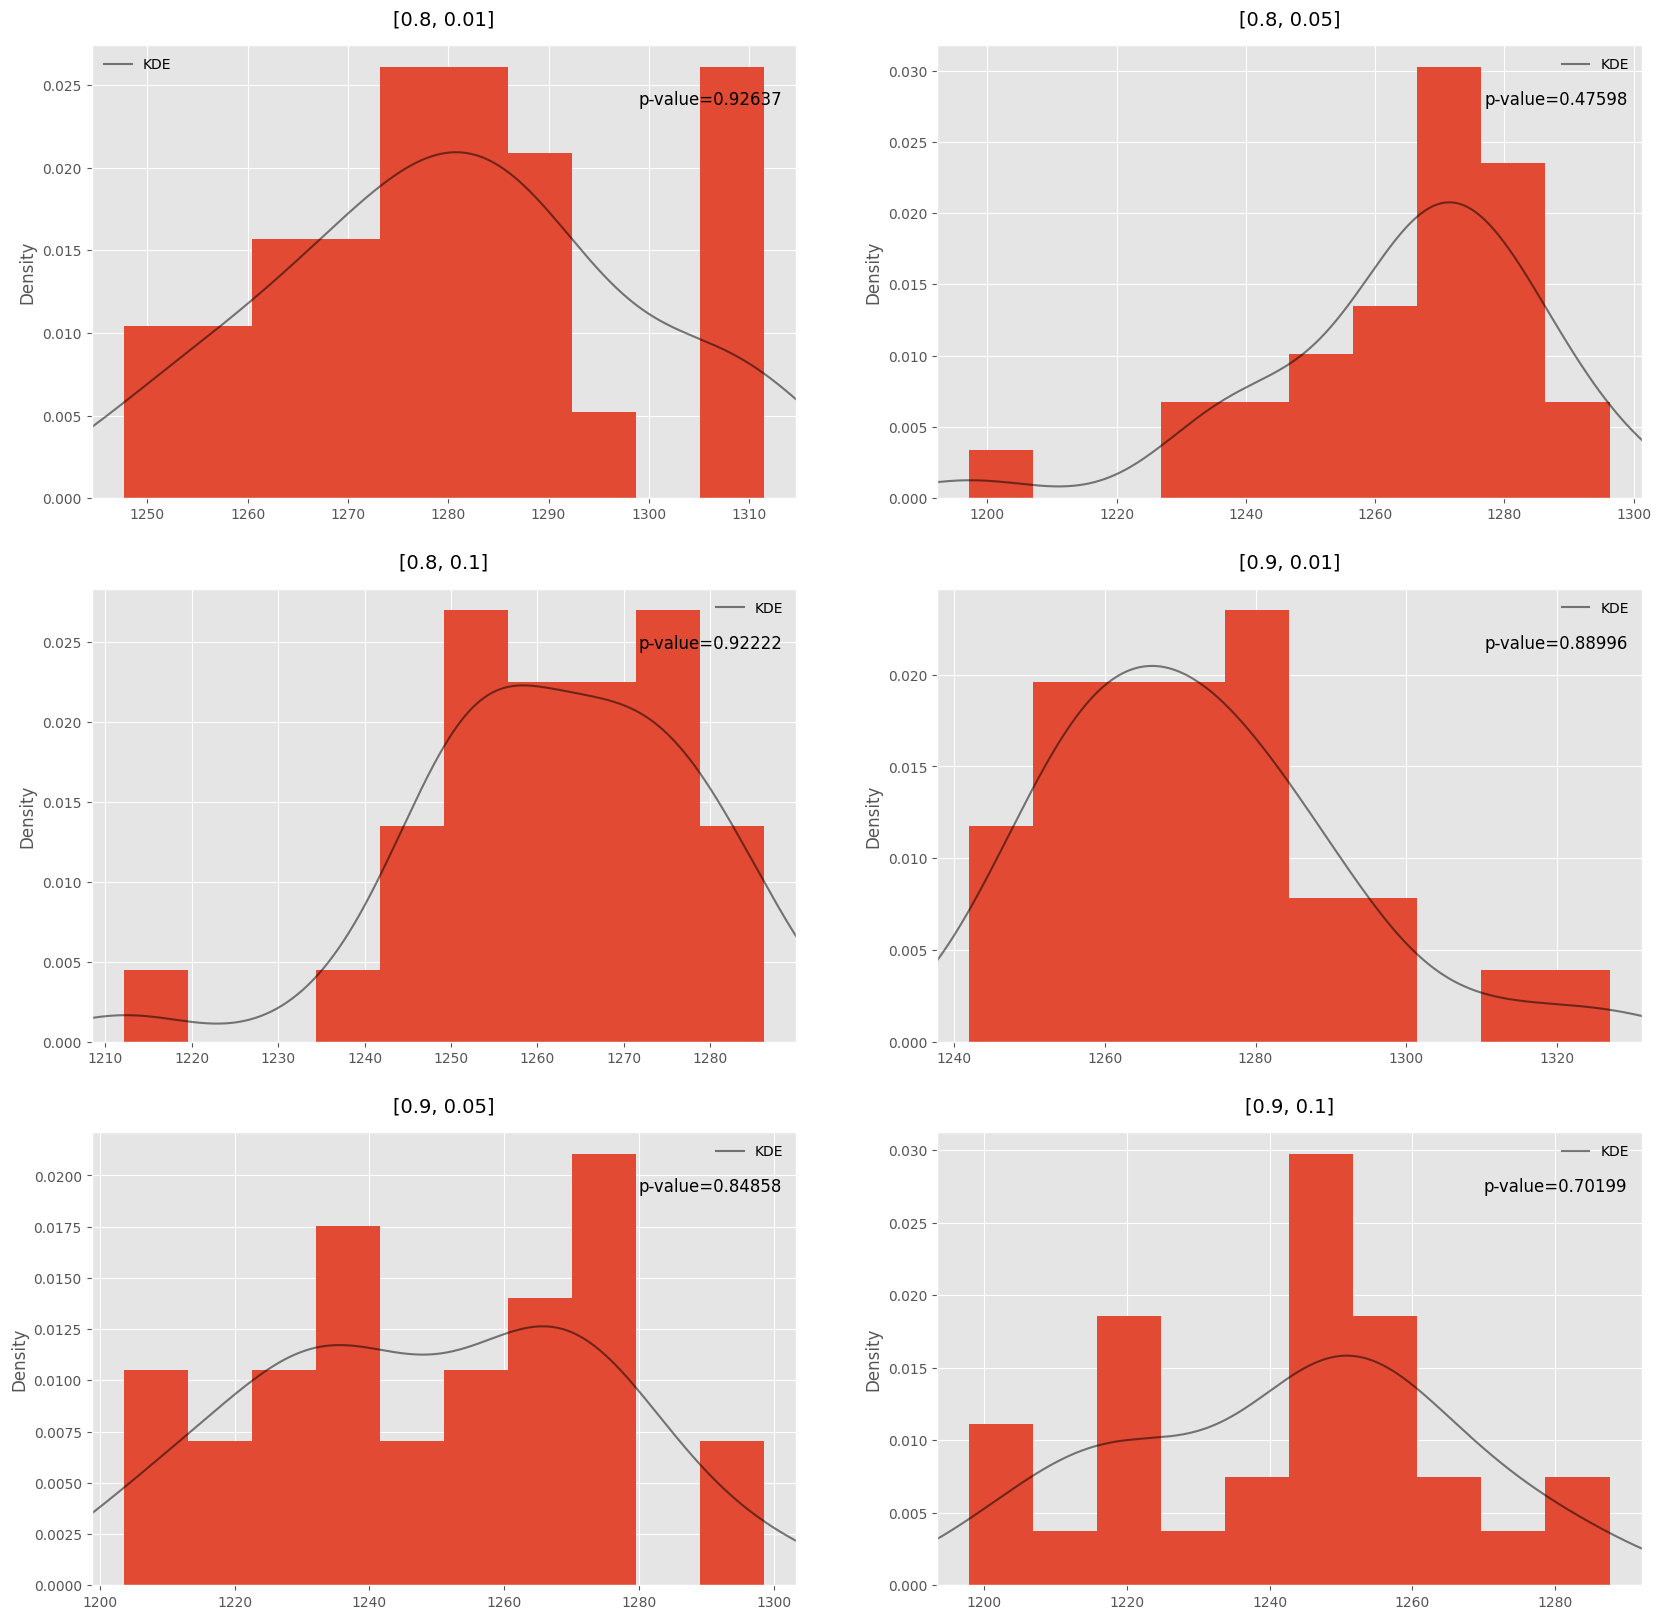

In [101]:
print_hist_plots(parametric, "parametric")

### **ANOVA**

In [102]:
f_oneway(*[parametric[col] for col in parametric.columns])

F_onewayResult(statistic=14.03663642461185, pvalue=1.575577368841548e-11)

The p-value is 1.5755e-11. <br>
Since it is less than 0.05, we reject $H_{0}$ (the null hypothesis). <br>
You have enough evidence to assert the existence of a difference in the means of the performance of the configurations.

### **Posthoc**

#### **t-Student**

In [103]:
parametric.head()

[0.8, 0.01]  [0.8, 0.05]   [0.8, 0.1]  [0.9, 0.01]  [0.9, 0.05]  \
0  1285.671766  1296.231587  1257.136032  1282.188690  1270.801786   
1  1277.800476  1266.708730  1277.859544  1293.368016  1203.522421   
2  1283.520714  1282.181905  1257.915040  1267.736964  1268.195933   
3  1268.604563  1296.280893  1212.099583  1276.484762  1238.116230   
4  1266.432718  1197.161528  1278.339365  1276.006925  1253.702222   

    [0.9, 0.1]  
0  1247.136131  
1  1222.599365  
2  1278.843651  
3  1276.717440  
4  1248.549722

In [104]:
fitness_by_method = parametric.melt(var_name='parameters', value_name='best_fitness')
fitness_by_method

parameters  best_fitness
0    [0.8, 0.01]   1285.671766
1    [0.8, 0.01]   1277.800476
2    [0.8, 0.01]   1283.520714
3    [0.8, 0.01]   1268.604563
4    [0.8, 0.01]   1266.432718
..           ...           ...
175   [0.9, 0.1]   1218.881627
176   [0.9, 0.1]   1227.741012
177   [0.9, 0.1]   1206.390020
178   [0.9, 0.1]   1256.998393
179   [0.9, 0.1]   1241.138274

[180 rows x 2 columns]

In [105]:
ttest_posthoc = ph.posthoc_ttest(fitness_by_method, 
                                 val_col='best_fitness', 
                                 group_col='parameters', 
                                 p_adjust='holm')
ttest_posthoc

[0.8, 0.01]  [0.8, 0.05]  [0.8, 0.1]  [0.9, 0.01]  [0.9, 0.05]  \
[0.8, 0.01]  1.000000e+00     0.018151    0.000669     0.279405     0.000009   
[0.8, 0.05]  1.815146e-02     1.000000    0.603387     0.499834     0.085718   
[0.8, 0.1]   6.690714e-04     0.603387    1.000000     0.147607     0.147607   
[0.9, 0.01]  2.794054e-01     0.499834    0.147607     1.000000     0.002484   
[0.9, 0.05]  9.193886e-06     0.085718    0.147607     0.002484     1.000000   
[0.9, 0.1]   2.566644e-08     0.002847    0.004044     0.000021     0.603387   

               [0.9, 0.1]  
[0.8, 0.01]  2.566644e-08  
[0.8, 0.05]  2.846815e-03  
[0.8, 0.1]   4.044384e-03  
[0.9, 0.01]  2.060808e-05  
[0.9, 0.05]  6.033868e-01  
[0.9, 0.1]   1.000000e+00

### **Now using tukey**

In [106]:

tukey2_posthoc = pairwise_tukeyhsd(endog=fitness_by_method['best_fitness'], 
                                   groups=fitness_by_method['parameters'], 
                                   alpha=0.05)
tukey2_posthoc.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

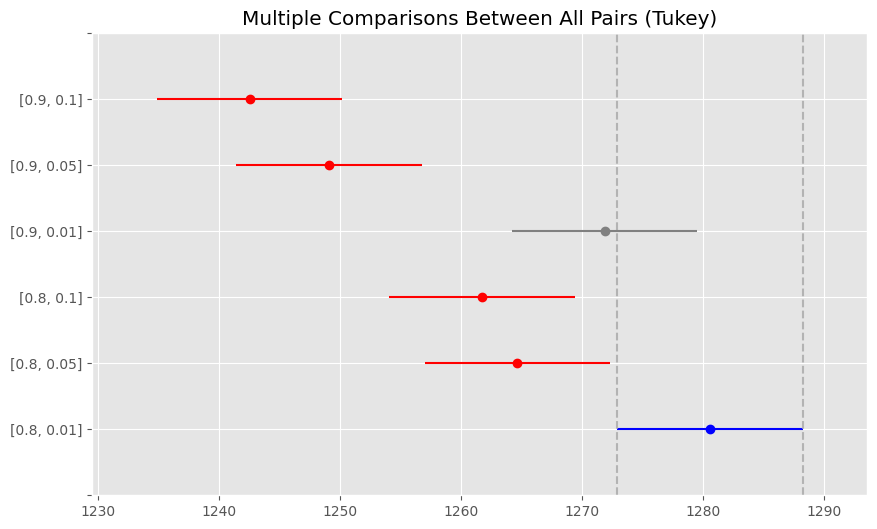

In [107]:
fig = tukey2_posthoc.plot_simultaneous(comparison_name='[0.8, 0.01]')

#### Ranking

In [108]:
get_differences_df(ttest_posthoc, results)

Config1      Config2  best_historical_fitness  avg_best_fitness  \
0  [0.8, 0.01]  [0.8, 0.05]                50.454325         15.905402   
1  [0.8, 0.01]   [0.8, 0.1]                35.516270         18.805210   
2  [0.8, 0.01]  [0.9, 0.05]                44.093433         31.454173   
3  [0.8, 0.01]   [0.9, 0.1]                49.678909         38.021956   
4  [0.8, 0.05]   [0.9, 0.1]                -0.775417         22.116554   
5   [0.8, 0.1]   [0.9, 0.1]                14.162639         19.216745   
6  [0.9, 0.01]  [0.9, 0.05]                38.416111         22.765354   
7  [0.9, 0.01]   [0.9, 0.1]                44.001587         29.333137   

   std_fitness   avg_time  
0    -3.386813  -4.313221  
1     1.499448 -10.697836  
2    -7.805998 -35.498707  
3    -5.762953 -37.318566  
4    -2.376140 -33.005345  
5    -7.262401 -26.620731  
6    -6.392886  -1.890985  
7    -4.349841  -3.710844

In [109]:
get_ranking(ttest_posthoc, results)

Config  appearances  wins  ranked
1  [0.8, 0.05]            2     2    1.00
4  [0.9, 0.05]            2     2    1.00
0   [0.9, 0.1]            4     3    0.75
5   [0.8, 0.1]            2     1    0.50
2  [0.8, 0.01]            4     0    0.00
3  [0.9, 0.01]            2     0    0.00

In [110]:
results

CXPB  MUTPB  best_historical_fitness  avg_best_fitness  std_fitness  \
0   0.8   0.01              1247.615853       1280.579688    17.192971   
1   0.8   0.05              1197.161528       1264.674286    20.579784   
2   0.8   0.10              1212.099583       1261.774478    15.693523   
3   0.9   0.01              1241.938532       1271.890869    18.606082   
4   0.9   0.05              1203.522421       1249.125515    24.998969   
5   0.9   0.10              1197.936944       1242.557732    22.955924   

     avg_time   p-value  
0  420.956239  0.926373  
1  425.269461  0.475978  
2  431.654075  0.922218  
3  454.563961  0.889964  
4  456.454946  0.848576  
5  458.274806  0.701994

As can be seen in the results, both the best historical fitness and the average fitness are at a minimum for the combination of [0.9, 0.10]. There is evidence to suggest that this combination is better than the others with a confidence level of 0.05, except for [0.9, 0.05]. Nevertheless, the decision is made to choose [0.9, 0.10] because the difference in time is not significant, and it performed better in other attributes.

Another observation to note is that, even though the chosen combination ranks third, it only "loses" to the combination [0.8, 0.05], but since the margin is minimal (-0.775417), we choose to disregard this detail and opt for the mentioned combination, considering that it achieves a better average fitness.

### **Additional configuration analysis**

In [111]:
informales = pd.read_csv(os.path.join(BFE, "best_fit_per_config_informal.csv"))
informales.head()


[2]          [3]
0  1295.056369  1332.464226
1  1314.083492  1307.888571
2  1321.953571  1319.988810
3  1280.405496  1286.903373
4  1315.279841  1268.527599

In [112]:
best_fitness_informal = pd.read_csv(os.path.join(RESULTS, "informal.csv"))
best_fitness_informal.head()

tournament_size  best_historical_fitness  avg_best_fitness  std_fitness  \
0                2              1277.845000       1287.592392    18.530151   
1                3              1337.026012       1295.067064    21.619478   

     avg_time   p-value  
0  478.450672  0.872560  
1  491.637074  0.986265

#### **Normality**

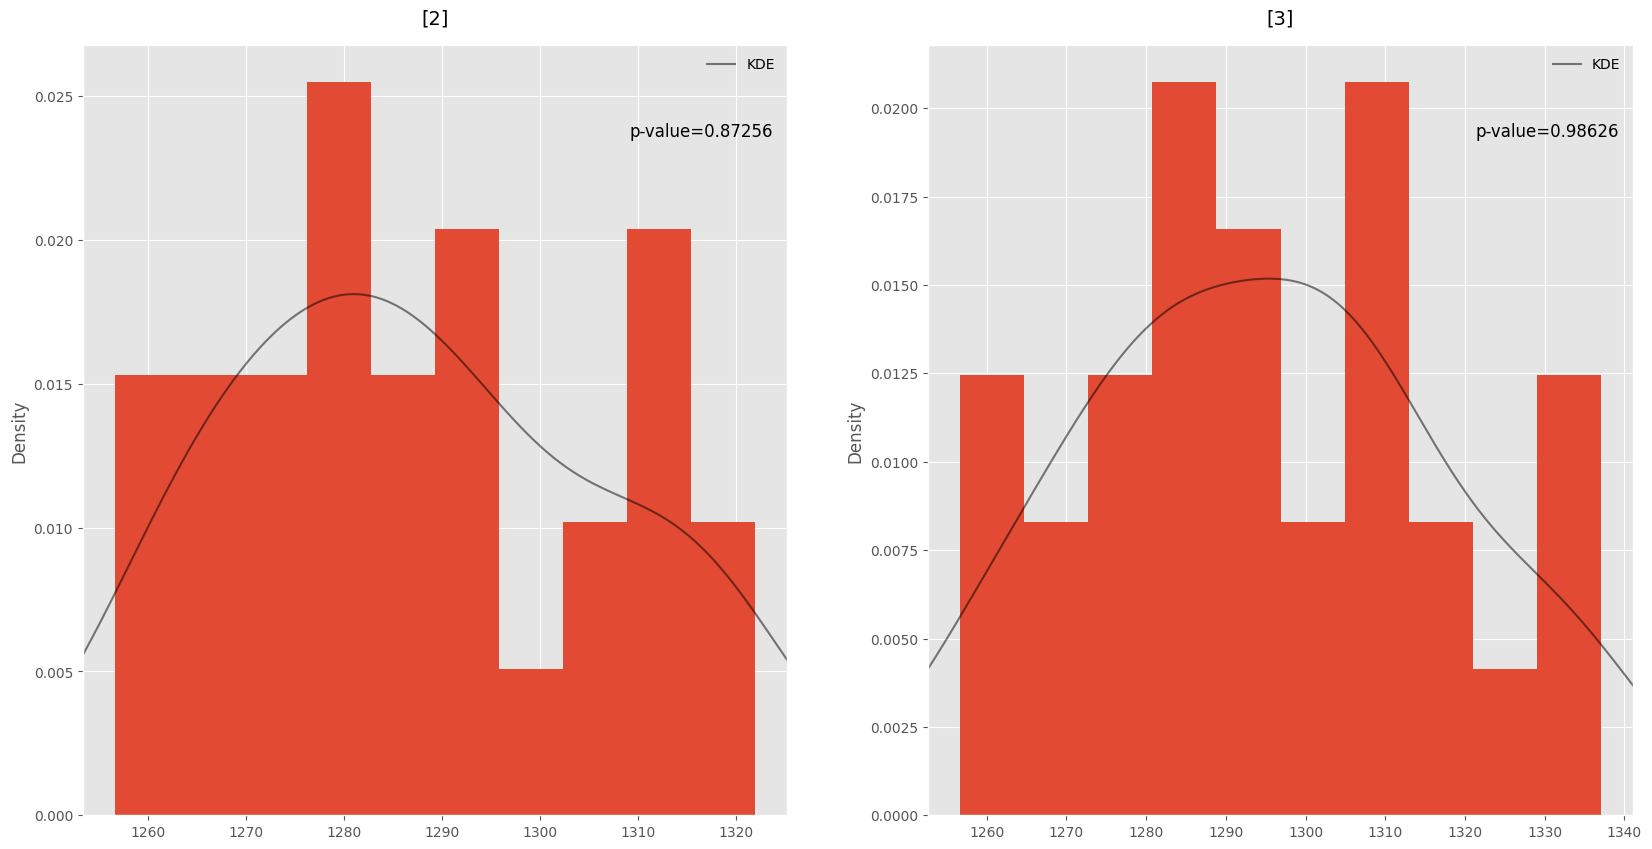

In [113]:
print_hist_plots(informales, "informal", size=(20,10))

De aquí resulta que no se rechaza la hipótesis de normalidad.

### **ANOVA**

In [114]:
# anova test
f_oneway(*[informales[col] for col in informales.columns])

F_onewayResult(statistic=1.9984146097807995, pvalue=0.16280886774821413)

Como el p-value no es menor a 0.05 entonces no se puede rechazar la $H_{0}$ y entonces no hay evidencia estadisticamente significativa para decir que hay una diferencia entre la media de uno y otro.

##### Considerando la configuracion previa

In [115]:
#add column from parametric
informales["best_config"] = parametric["[0.9, 0.1]"]
informales

[2]          [3]  best_config
0   1295.056369  1332.464226  1247.136131
1   1314.083492  1307.888571  1222.599365
2   1321.953571  1319.988810  1278.843651
3   1280.405496  1286.903373  1276.717440
4   1315.279841  1268.527599  1248.549722
5   1293.773413  1301.607123  1249.432738
6   1277.621806  1256.683413  1287.581607
7   1262.963056  1272.258710  1197.936944
8   1320.792480  1273.519583  1243.948294
9   1304.860794  1304.547143  1269.324603
10  1286.418075  1307.091964  1247.948194
11  1261.781230  1261.218095  1250.915119
12  1302.991290  1329.491468  1258.559841
13  1267.169940  1286.157579  1204.555734
14  1264.363829  1277.890139  1258.754782
15  1280.997579  1290.573571  1244.814067
16  1289.685119  1282.791806  1267.365615
17  1312.386448  1282.040238  1220.594246
18  1286.914603  1283.571667  1236.446409
19  1272.839127  1312.953056  1255.832996
20  1290.592877  1260.104762  1218.370476
21  1311.051885  1328.915972  1248.756290
22  1289.065198  1295.697956  1214.497520
23  1256.577044  1278.530238  1216.158790
24  1264.987817  1296.084127  1259.942063
25  1275.350079  1306.534901  1218.881627
26  1279.126508  1308.474583  1227.741012
27  1273.225437  1305.882004  1206.390020
28  1297.612341  1296.593234  1256.998393
29  1277.845000  1337.026012  1241.138274

In [116]:
fitness_by_method = informales.melt(var_name='parameters', value_name='best_fitness')
fitness_by_method

parameters  best_fitness
0           [2]   1295.056369
1           [2]   1314.083492
2           [2]   1321.953571
3           [2]   1280.405496
4           [2]   1315.279841
..          ...           ...
85  best_config   1218.881627
86  best_config   1227.741012
87  best_config   1206.390020
88  best_config   1256.998393
89  best_config   1241.138274

[90 rows x 2 columns]

In [117]:
posthoc = ph.posthoc_ttest(fitness_by_method, val_col='best_fitness', group_col='parameters', p_adjust='holm')
posthoc

[2]           [3]   best_config
[2]          1.000000e+00  1.628089e-01  5.234705e-11
[3]          1.628089e-01  1.000000e+00  4.505137e-12
best_config  5.234705e-11  4.505137e-12  1.000000e+00

From these results, there is not a very clear difference between different parameters for tournament selection. 

However, the superiority of elitist selection is perceived as considerably better, so it is decided to retain this parameter for the subsequent stage.

### **Selection of best configuration**

selBest $\land$ [CXPB, MUTPB] = [0.9, 0.1] <br>	

### **Comparison**

In [118]:
comparison = pd.read_csv(os.path.join(BFE, "best_fit_per_config_comparison.csv"))
comparison.head()

EA-fox.jpg  local_search-fox.jpg  gaussian-fox.jpg  EA-monalisa_sqr.jpg  \
0  206.205779            178.727454        217.944707           128.088327   
1  204.505092            213.027538        251.575729           141.387280   
2  202.432027            180.842462        204.394925           129.635065   
3  207.050988            188.781173        198.866147           135.253307   
4  199.235377            187.041926        244.780586           131.043559   

   local_search-monalisa_sqr.jpg  gaussian-monalisa_sqr.jpg  EA-old_man.jpeg  \
0                     170.901686                 121.684703       620.110249   
1                     164.205103                 126.966647       625.799156   
2                     166.876867                 116.537048       601.603493   
3                     169.887532                 112.575717       608.201813   
4                     165.759606                 139.946466       619.988702   

   local_search-old_man.jpeg  gaussian-old_man.jpeg  
0                 592.374942             561.641796  
1                 557.003547             581.014400  
2                 570.560133             620.294347  
3                 602.707431             646.899591  
4                 587.620631             632.211982

In [119]:
instancia1, instancia2, instancia3 = \
    (comparison.iloc[0:30, 3*i:3*i+3] for i in range(3))

#### **Normality**

In [120]:
for idx, instancia in enumerate([instancia1, instancia2, instancia3]):
    print(f"<---Instance number: {idx}--->")
    for col in instancia.columns:
        print(col, " ", normality_test(instancia[col]))
    print()

<---Instance number: 0--->
EA-fox.jpg   0.913111485944283
local_search-fox.jpg   0.4603965723494652
gaussian-fox.jpg   0.8799956397939868

<---Instance number: 1--->
EA-monalisa_sqr.jpg   0.32647624891826243
local_search-monalisa_sqr.jpg   0.5200178799236967
gaussian-monalisa_sqr.jpg   0.56352268067586

<---Instance number: 2--->
EA-old_man.jpeg   0.8294676981876595
local_search-old_man.jpeg   0.46065387458214646
gaussian-old_man.jpeg   0.9711059909255659



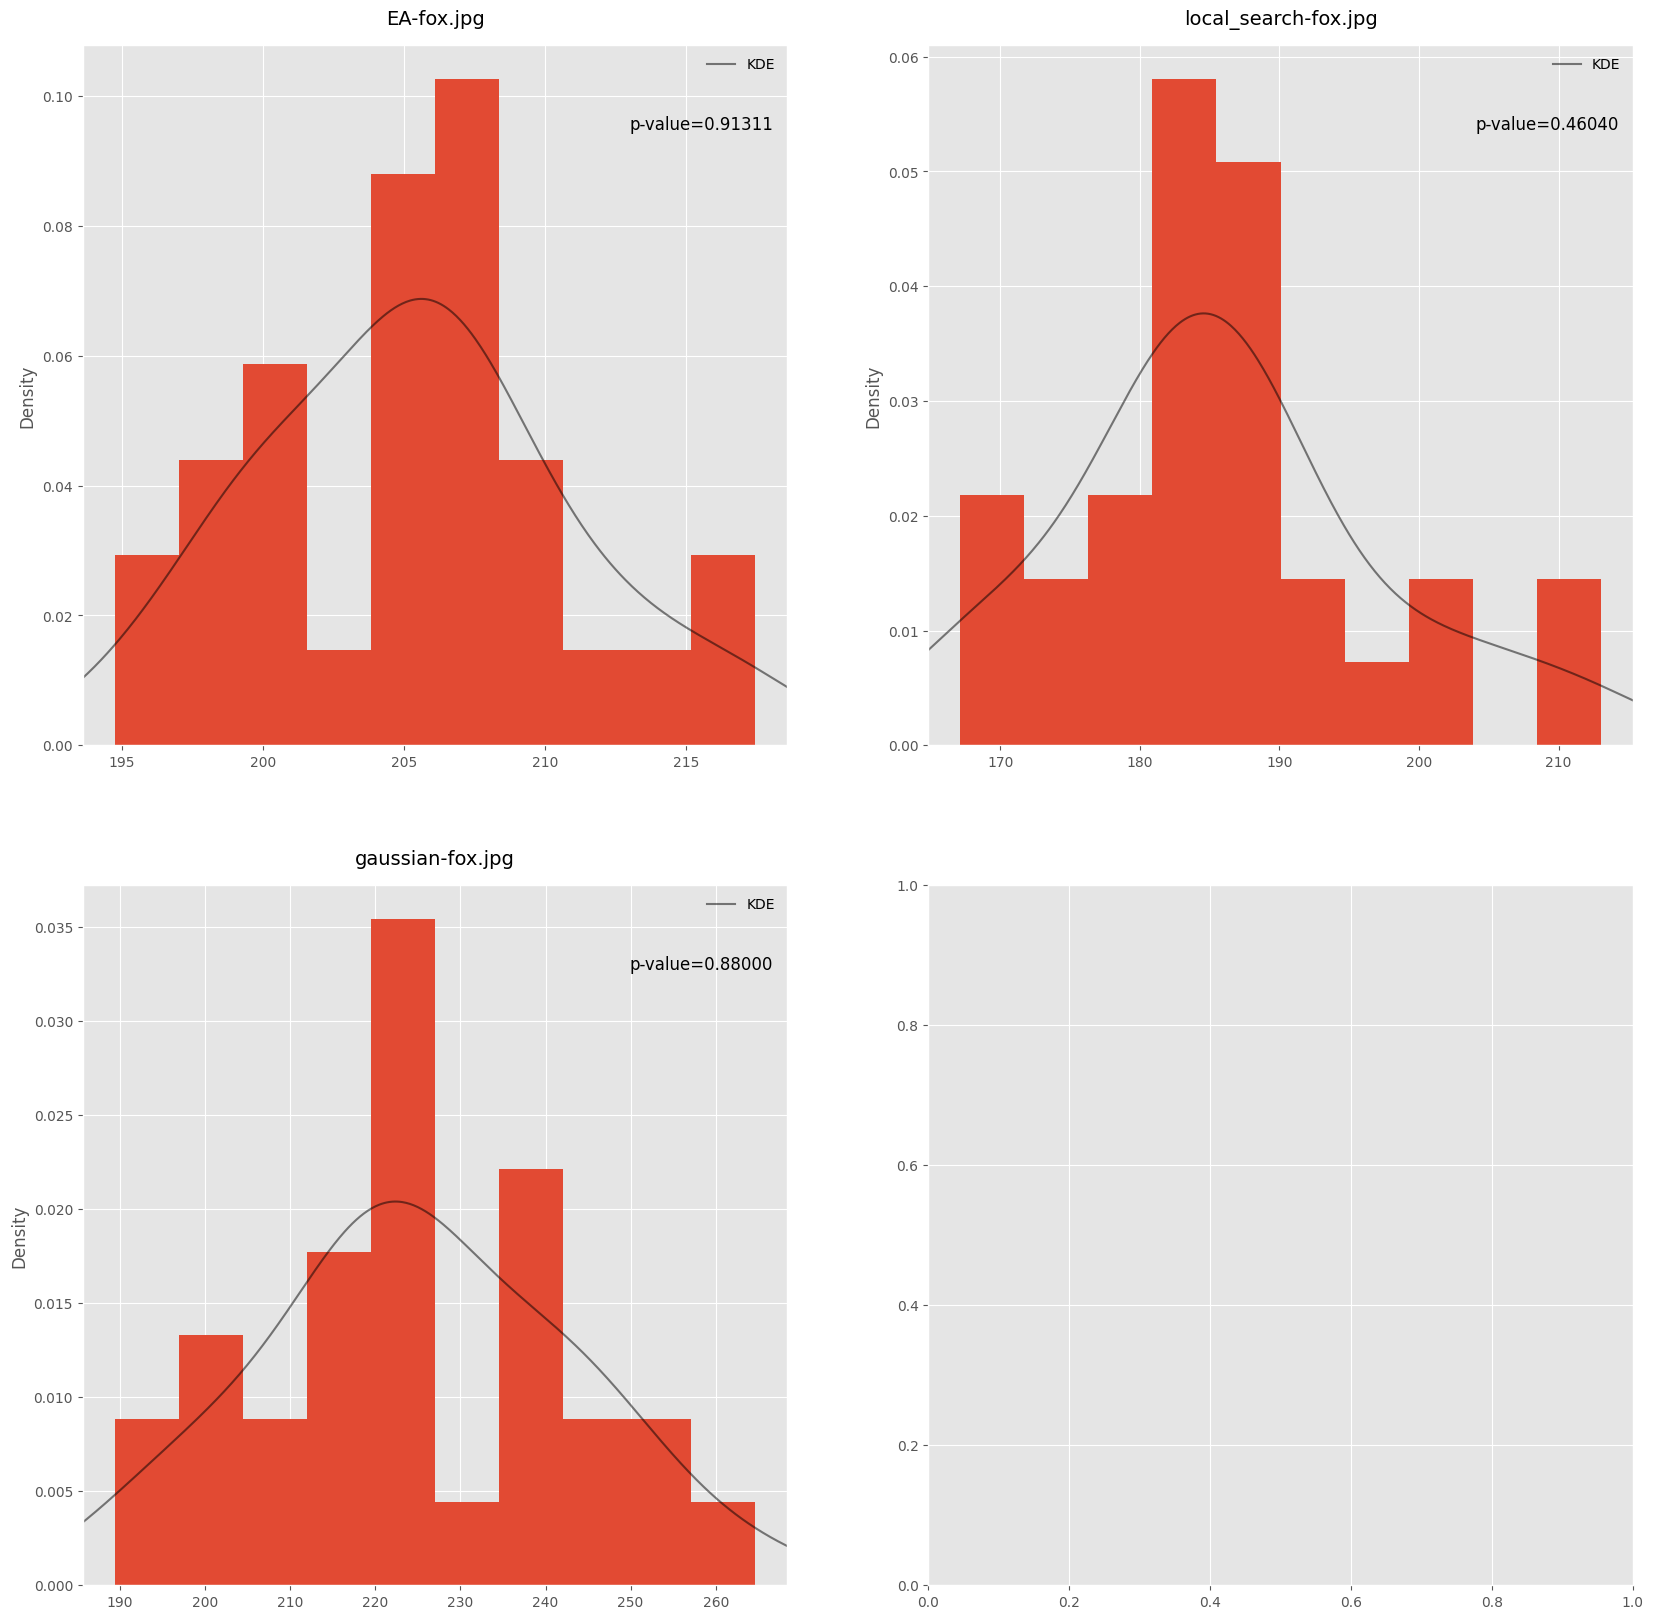

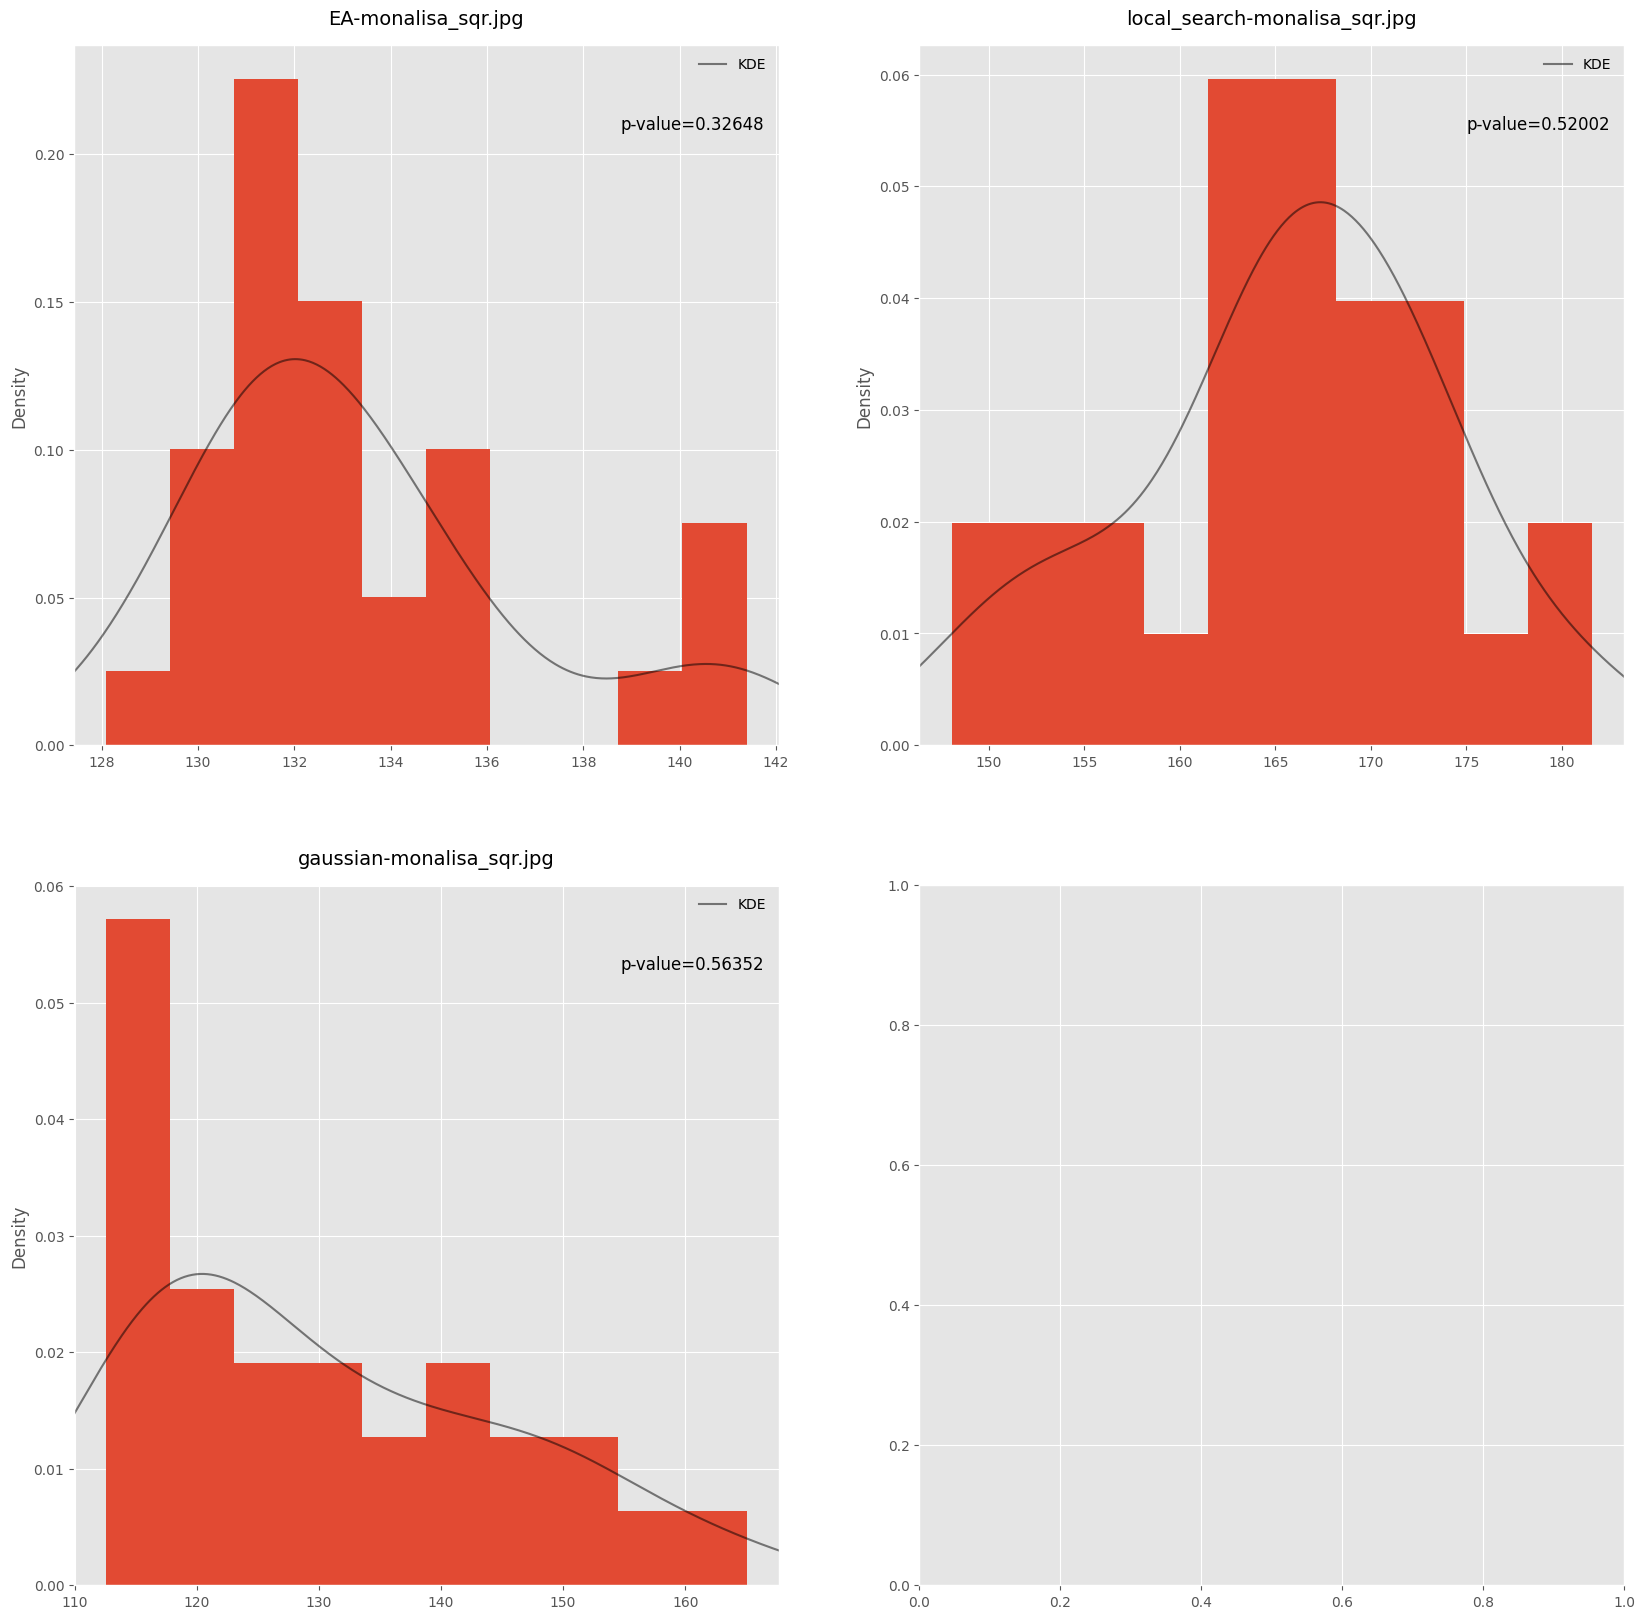

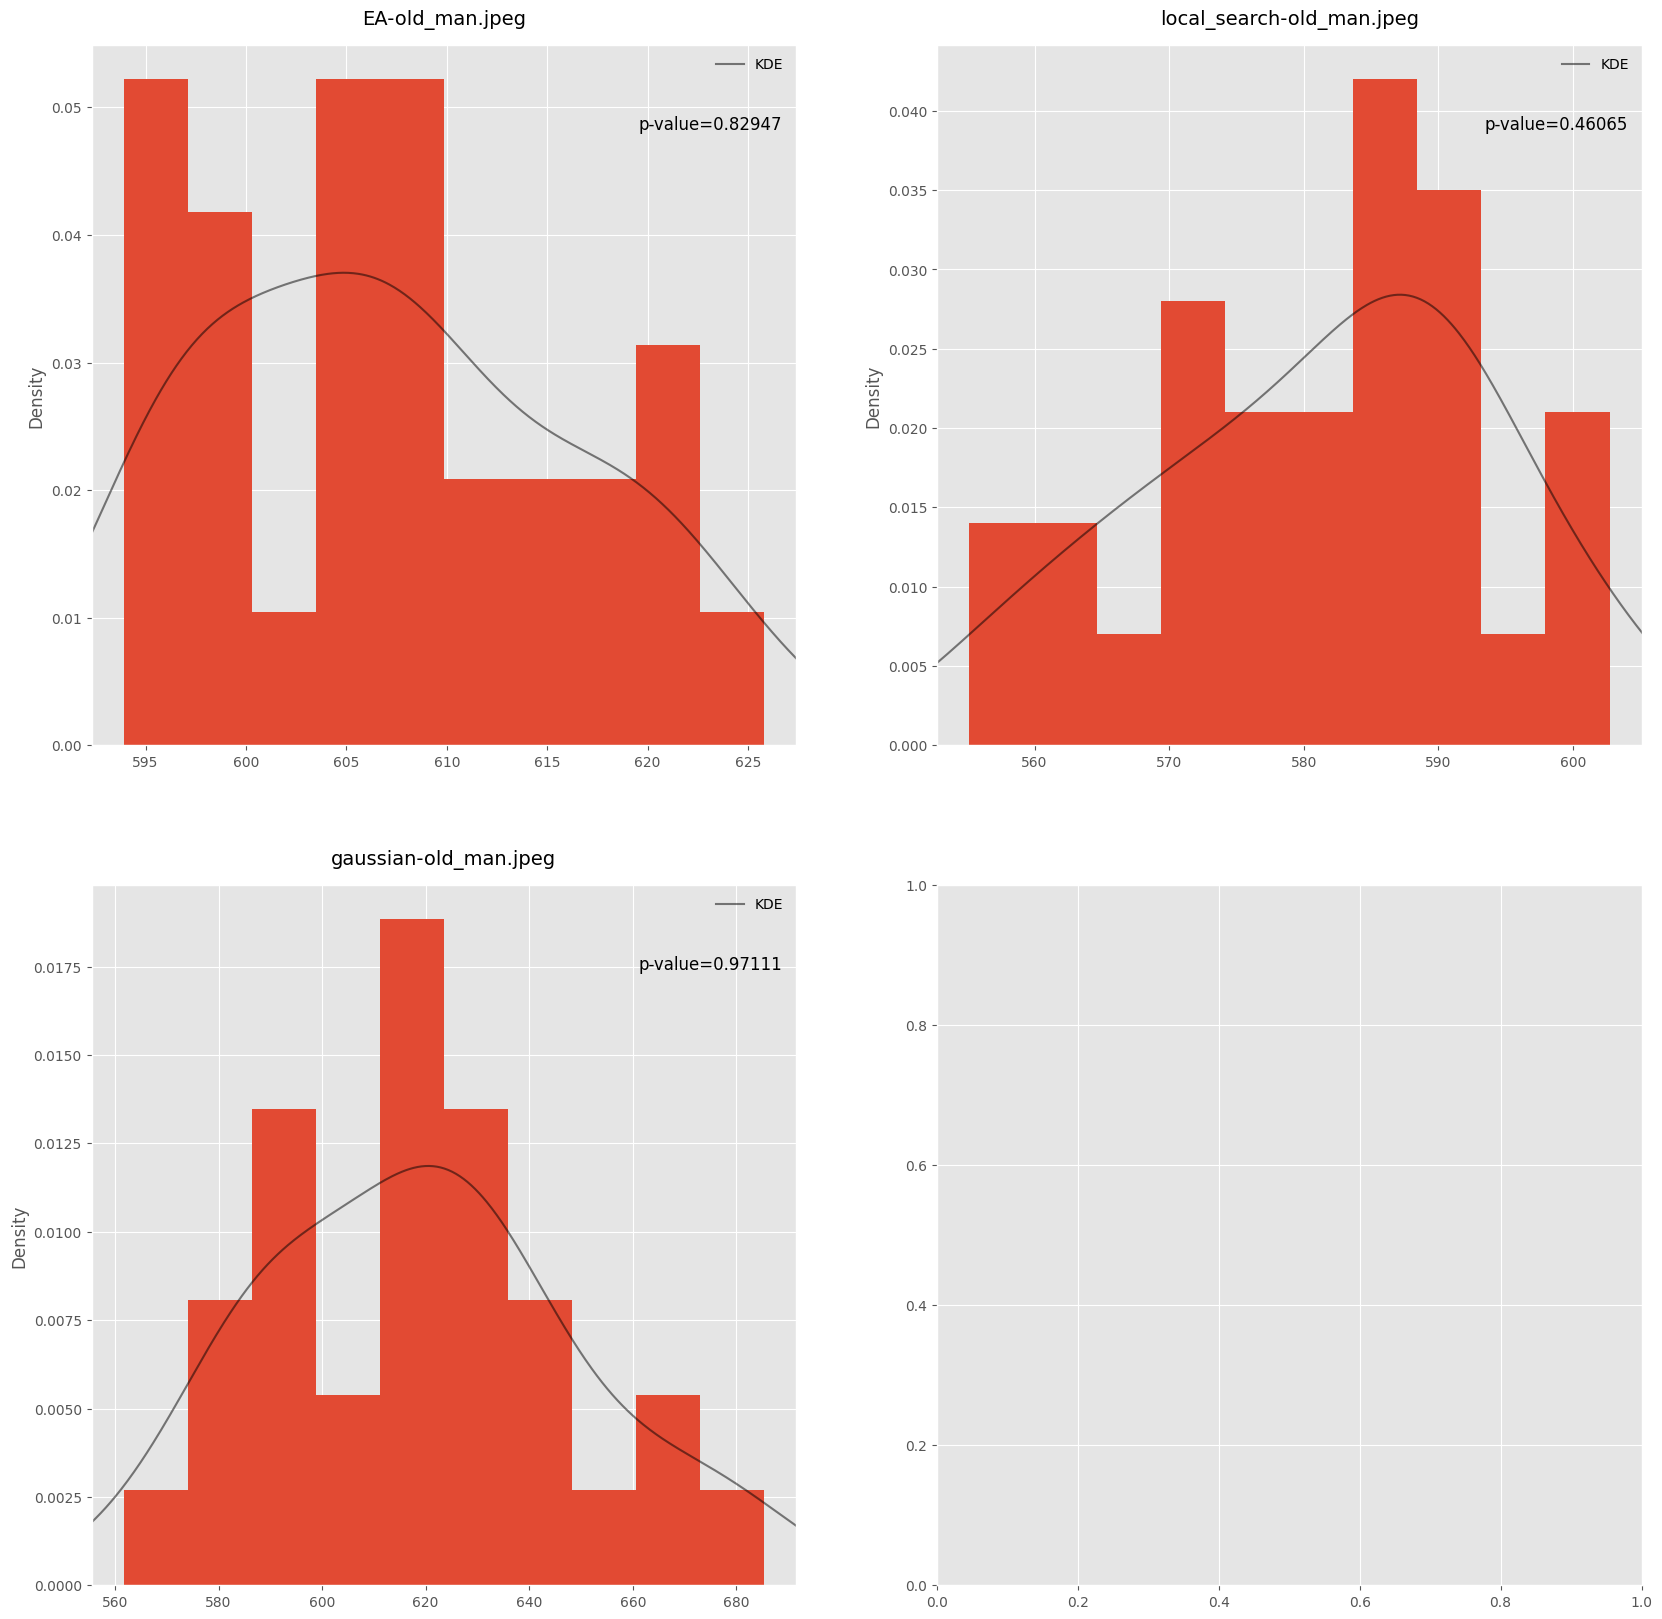

In [121]:
print_hist_plots(instancia1, "comparison_instancia1")
print_hist_plots(instancia2, "comparison_instancia2")
print_hist_plots(instancia3, "comparison_instancia3")

Conclusion: $H_{0}$ is not rejected, and the data is assumed to be normal.

#### **ANOVA**

In [122]:
for instancia in [instancia1, instancia2, instancia3]:
    print(f_oneway(*[instancia[col] for col in instancia.columns]))

F_onewayResult(statistic=70.71043851586754, pvalue=5.8087196954496455e-19)
F_onewayResult(statistic=115.56375672000858, pvalue=3.20578168270887e-25)
F_onewayResult(statistic=28.687350623940322, pvalue=2.699135589260827e-10)


Very low p-values -> reject $H_{0}$, there is statistically significant evidence to say that there is a difference between the means of at least one pair.

#### **Posthoc**

In [123]:
best_fitnesses_comparison = [inst.melt(var_name='method-image',
                                       value_name='best_fitness')
                             for inst in [instancia1, instancia2, instancia3]]
best_fitnesses_comparison

[        method-image  best_fitness
 0         EA-fox.jpg    206.205779
 1         EA-fox.jpg    204.505092
 2         EA-fox.jpg    202.432027
 3         EA-fox.jpg    207.050988
 4         EA-fox.jpg    199.235377
 ..               ...           ...
 85  gaussian-fox.jpg    211.207940
 86  gaussian-fox.jpg    220.035662
 87  gaussian-fox.jpg    247.241055
 88  gaussian-fox.jpg    189.391407
 89  gaussian-fox.jpg    221.855611
 
 [90 rows x 2 columns],
                  method-image  best_fitness
 0         EA-monalisa_sqr.jpg    128.088327
 1         EA-monalisa_sqr.jpg    141.387280
 2         EA-monalisa_sqr.jpg    129.635065
 3         EA-monalisa_sqr.jpg    135.253307
 4         EA-monalisa_sqr.jpg    131.043559
 ..                        ...           ...
 85  gaussian-monalisa_sqr.jpg    124.293611
 86  gaussian-monalisa_sqr.jpg    132.277649
 87  gaussian-monalisa_sqr.jpg    141.394677
 88  gaussian-monalisa_sqr.jpg    117.774432
 89  gaussian-monalisa_sqr.jpg    114.032997
 


#### **t-Student Test**

In [124]:
posthocs = []
for best_fitness in best_fitnesses_comparison:
    posthoc = ph.posthoc_ttest(best_fitness, val_col='best_fitness', group_col='method-image', p_adjust='holm')
    posthocs.append(posthoc)

In [125]:
posthocs[0]

EA-fox.jpg  local_search-fox.jpg  gaussian-fox.jpg
EA-fox.jpg            1.000000e+00          2.191145e-11      4.337723e-07
local_search-fox.jpg  2.191145e-11          1.000000e+00      8.437700e-14
gaussian-fox.jpg      4.337723e-07          8.437700e-14      1.000000e+00

In [126]:
posthocs[1]

EA-monalisa_sqr.jpg  \
EA-monalisa_sqr.jpg                   1.000000e+00   
local_search-monalisa_sqr.jpg         2.825009e-27   
gaussian-monalisa_sqr.jpg             3.197411e-01   

                               local_search-monalisa_sqr.jpg  \
EA-monalisa_sqr.jpg                             2.825009e-27   
local_search-monalisa_sqr.jpg                   1.000000e+00   
gaussian-monalisa_sqr.jpg                       3.975395e-16   

                               gaussian-monalisa_sqr.jpg  
EA-monalisa_sqr.jpg                         3.197411e-01  
local_search-monalisa_sqr.jpg               3.975395e-16  
gaussian-monalisa_sqr.jpg                   1.000000e+00

In [127]:
posthocs[2]

EA-old_man.jpeg  local_search-old_man.jpeg  \
EA-old_man.jpeg               1.000000e+00               3.824340e-12   
local_search-old_man.jpeg     3.824340e-12               1.000000e+00   
gaussian-old_man.jpeg         4.560022e-02               9.743074e-08   

                           gaussian-old_man.jpeg  
EA-old_man.jpeg                     4.560022e-02  
local_search-old_man.jpeg           9.743074e-08  
gaussian-old_man.jpeg               1.000000e+00

There is no significant evidence to prove that the Gaussian mutation method is better than the EA except for the image fox.jpg. Furthermore, the image old_man is significant, although not for alpha=0.05; it could also be considered superior in that case for alpha=0.10. On the other hand, for monalisa, it doesn't demonstrate superiority, and even the EA achieves a better average fitness.

This result is discouraging, although it's worth noting that the evolutionary algorithm achieves its objective in much less average time, despite the number of operations performed in an evolutionary algorithm. It's important to highlight that, given the elitism of the EA, the best fitness is generally achieved much earlier than the maximum number of generations.

It's also possible that there exists a configuration of mutation values (for example, for a gene or an individual) in the evolutionary algorithm for which it behaves similarly to the Gaussian algorithm. Therefore, it can be concluded that even though it surpasses it, there may be a configuration that achieves better results since essentially the same operation is being performed, albeit without other characteristic operators of an EA.

#### **Others**

In [128]:
for posthoc_table,instance in zip(posthocs, ["fox", "monalisa", "oldman"]):
    pvalues = []
    for i, row_index in enumerate(posthoc_table.index):
        for j, col in enumerate(posthoc_table.columns):
            if i < j:
                pvalue = [row_index, col,posthoc_table.loc[row_index, col]]
                pvalues.append(pvalue)
                
    pvalues_df = pd.DataFrame(pvalues, columns=["Config1", "Config2", "p-value"])
    pvalues_df.to_csv(f"{RESULTS}pvaluesphttest{instance}.csv", index=False)

In [129]:
time = pd.read_csv(os.path.join(RESULTS, "reports", "test_time.csv"))
time

CPU        time   speedup  efficiency
0     1  394.266333  1.000000    1.000000
1     2  222.068764  1.775425    0.887712
2     3  169.152850  2.330829    0.776943
3     4  145.106739  2.717078    0.679270
4     1  557.445518  1.000000    1.000000
5     2  311.957278  1.263847    0.631924
6     3  233.584950  1.687893    0.562631
7     4  197.812029  1.993136    0.498284
8     1  783.073144  1.000000    1.000000
9     2  460.797073  0.855618    0.427809
10    3  348.820561  1.130284    0.376761
11    4  301.556543  1.307438    0.326859

In [130]:
csv_files = [os.path.join(RESULTS, "informal.csv"),
             os.path.join(RESULTS, "comparison.csv"),
             os.path.join(RESULTS, "resultados.csv")]
dfs = [pd.read_csv(csv_file) for csv_file in csv_files]

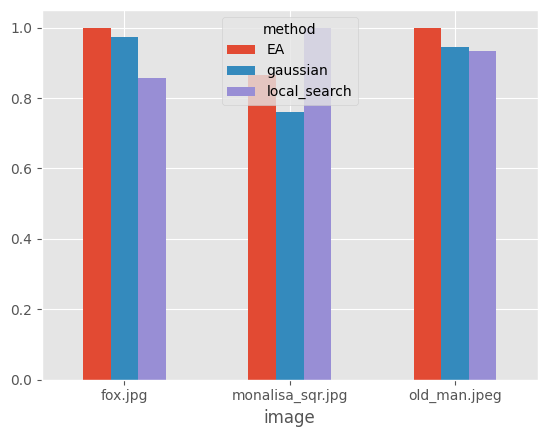

In [131]:
stats = Statistics()
results_dir = os.path.join(RESULTS, "comparison.csv")
historical_fitness_dir = os.path.join(RESULTS, "plots", "best_historical_fitness.png")
stats.plot_best_historical_fitness(results_dir=results_dir,
                                   historical_fitness_dir=historical_fitness_dir)

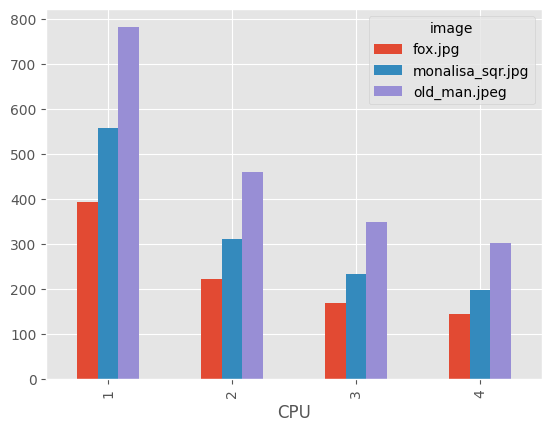

In [132]:
test_time_dir = os.path.join(RESULTS, "plots", "time.png")
results_dir = os.path.join(RESULTS, "reports", "test_time.csv")
stats.plot_time(time_dir=test_time_dir, results_dir=results_dir)